In [1]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

## Table of Contents

* [1. Introduction](#1)
 * [1.1 References](#1.1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 Random forest classifier](#8.2)
 * [8.3 k-nearest neighbors](#8.3)
 * [8.4 Tune hyperparameters on the chosen model more finely](#8.4)
 * [8.5 Test set evaluation](#8.5)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References
<a id="1.1"></a>

* LendingClub information
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Datasets
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source, aggregated on Kaggle
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project
* This project
 * [Kaggle notebook](https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
 * [GitHub repo](https://github.com/jgcorliss/lending-club)

# 2. Import the Data
<a id="2"></a>

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read the data into a pandas dataframe:

In [3]:
loans = pd.read_csv('./archive/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Check basic dataframe info:

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


There are 1.6 million rows and 150 variables. The size of the dataset is 1.8 GB.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [5]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
468956,128974253,NaN,15600.0,15600.0,15600.0,36 months,15.05,541.17,C,C4,Owner,3 years,RENT,62000.0,Verified,Feb-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=128974253,NaN,debt_consolidation,Debt consolidation,286xx,NC,10.68,0.0,Nov-2006,690.0,694.0,0.0,44.0,NaN,12.0,0.0,12022.0,44.4,21.0,w,10754.19,10754.19,7009.120000,7009.12,4845.81,2163.31,0.0,0.0,0.0,Mar-2019,541.17,Apr-2019,Mar-2019,719.0,715.0,0.0,46.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,13731.0,0.0,1.0,0.0,1.0,14.0,1709.0,67.0,3.0,9.0,4199.0,46.0,27100.0,0.0,0.0,1.0,10.0,1144.0,13678.0,46.8,0.0,0.0,120.0,135.0,9.0,9.0,0.0,9.0,NaN,10.0,46.0,1.0,9.0,9.0,9.0,9.0,9.0,11.0,12.0,9.0,12.0,0.0,0.0,0.0,3.0,90.5,11.1,0.0,0.0,29664.0,13731.0,25700.0,2564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1597312,131318417,NaN,20000.0,20000.0,20000.0,36 months,10.41,649.21,B,B3,Union Laborer,< 1 year,RENT,70000.0,Source Verified,Apr-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=131318417,NaN,credit_card,Credit card refinancing,082xx,NJ,21.91,0.0,Jun-2006,725.0,729.0,1.0,75.0,NaN,7.0,0.0,1447.0,14.5,10.0,w,14534.21,14534.21,7129.740000,7129.74,5465.79,1663.95,0.0,0.0,0.0,Mar-2019,649.21,Apr-2019,Mar-2019,764.0,760.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,49276.0,1.0,4.0,2.0,3.0,5.0,47829.0,84.0,0.0,1.0,1434.0,73.0,10000.0,8.0,0.0,9.0,4.0,7039.0,8553.0,14.5,0.0,0.0,105.0,142.0,20.0,5.0,0.0,20.0,75.0,6.0,75.0,0.0,2.0,2.0,3.0,5.0,5.0,3.0,5.0,2.0,7.0,0.0,0.0,0.0,2.

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [6]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [7]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [8]:
loans.shape

(1345310, 151)

There are 814,986 loans remaining. Check that the statuses are as expected:

In [9]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

Status counts as percentages:

In [10]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

About 79% of the remaining loans have been fully paid and 21% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [11]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

Top 10 features missing the most data:

In [12]:
missing_fractions.head(10)

member_id                                     1.000000
next_pymnt_d                                  1.000000
orig_projected_additional_accrued_interest    0.997206
hardship_start_date                           0.995723
hardship_end_date                             0.995723
payment_plan_start_date                       0.995723
hardship_length                               0.995723
hardship_dpd                                  0.995723
hardship_loan_status                          0.995723
hardship_last_payment_amount                  0.995723
dtype: float64

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

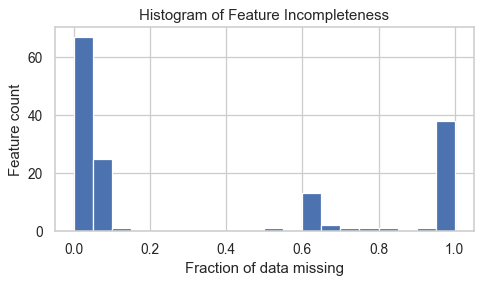

In [13]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [14]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [15]:
len(drop_list)

58

Drop these features:

In [16]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [17]:
loans.shape

(1345310, 93)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [18]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [19]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [20]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [21]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [22]:
len(drop_list)

62

Drop these features:

In [23]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [24]:
loans.shape

(1345310, 31)

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [25]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), palette = "Blues", saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', palette = "Spectral_r", data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, palette = "Blues",  saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [26]:
# def plot_var(col_name, full_name, continuous):
#     """
#     Visualize a variable with and without faceting on the loan status.
#     - col_name is the variable name in the dataframe
#     - full_name is the full variable name
#     - continuous is True if the variable is continuous, False otherwise
#     """
#     f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
#     # Plot without loan status
#     if continuous:
#         sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
#     else:
#         sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4']]], saturation=1, ax=ax1)
#     ax1.set_xlabel(full_name)
#     ax1.set_ylabel('Count')
#     ax1.set_title(full_name)

#     # Plot with loan status
#     if continuous:
#         sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
#         ax2.set_ylabel('')
#         ax2.set_title(full_name + ' by Loan Status')
#     else:
#         charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
#         sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
#         ax2.set_ylabel('Fraction of Loans Charged-off')
#         ax2.set_title('Charge-off Rate by ' + full_name)
#     ax2.set_xlabel(full_name)
    
#     plt.tight_layout()

Print the remaining features for future reference:

In [27]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [28]:
loans['id'].sample(5)

123679     60825342
252168     51836598
658860     83124474
2027698    84910362
1894318     2045294
Name: id, dtype: object

Are all the IDs unique?

In [29]:
loans['id'].describe()

count      1345310
unique     1345310
top       83886078
freq             1
Name: id, dtype: int64

Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [30]:
loans.drop('id', axis=1, inplace=True)

## 5.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [31]:
loans['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

Loan amounts range from \$500 to \$40,000, with a median of \$12,000.

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


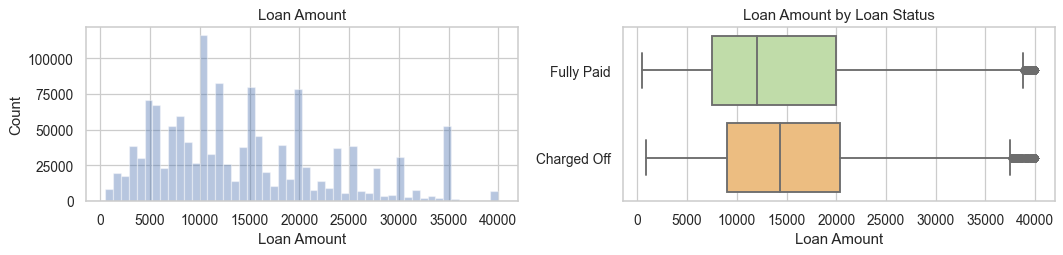

In [32]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [33]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0
Fully Paid,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0


## 5.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [34]:
loans['term'].value_counts(dropna=False)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

Convert `term` to integers.

In [35]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [36]:
loans['term'].value_counts(normalize=True)

36    0.758742
60    0.241258
Name: term, dtype: float64

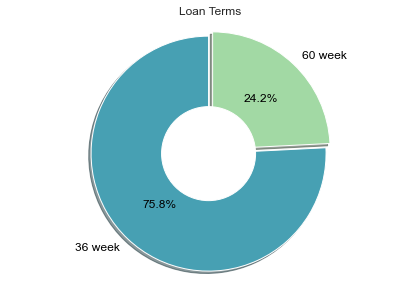

In [37]:
labels = np.array(['36 week', '60 week'])
sizes = np.array([75.8, 24.2])

explode = [0,0.05]
colors = sns.color_palette("Spectral_r")

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, explode = explode, labels=labels, autopct='%1.1f%%', startangle=90, shadow= True, 
        textprops = {'color': 'Black','fontsize':12},
                wedgeprops = {'linewidth': 1})
#draw circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Loan Terms')
plt.show()

Compare the charge-off rate by loan period:

In [38]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.159934
60    0.324454
Name: loan_status, dtype: float64

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.4 int_rate

Data Dictionary: "Interest Rate on the loan."

In [39]:
loans['int_rate'].describe()

count    1.345310e+06
mean     1.323962e+01
std      4.768716e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

Interest rates range from 5.32% to 30.99% (!) with a median of 13.1%.

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


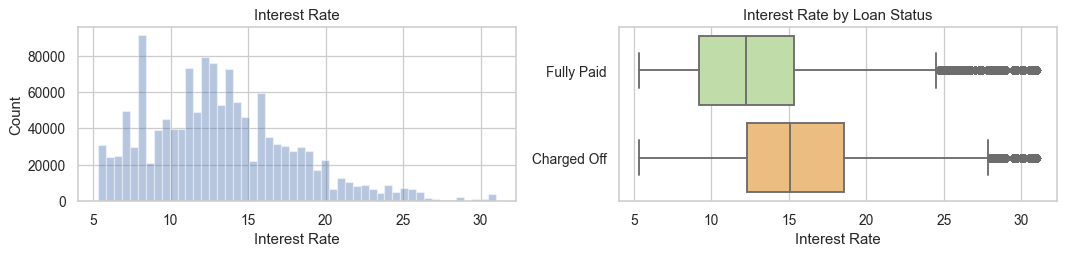

In [40]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [41]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99


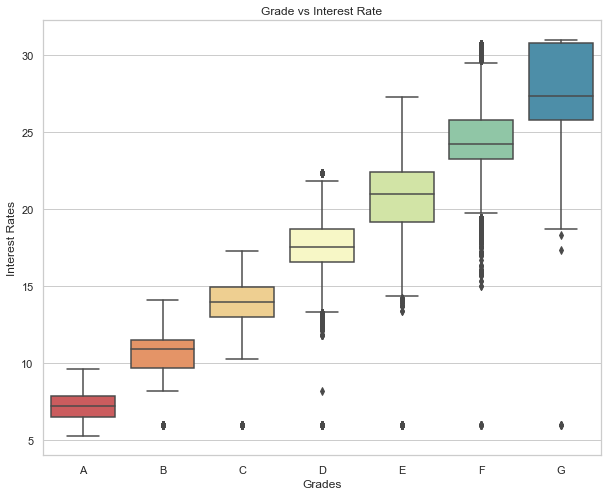

In [74]:
plt.figure(figsize=(10,8))
sns.boxplot(data = loans.sort_values('grade'), x='grade', y='int_rate', palette = 'Spectral')
plt.title('Grade vs Interest Rate')
plt.xlabel('Grades')
plt.ylabel('Interest Rates')
plt.show()


In [ ]:
sns.barplot()

## 5.5 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [43]:
loans['installment'].describe()

count    1.345310e+06
mean     4.380755e+02
std      2.615126e+02
min      4.930000e+00
25%      2.484800e+02
50%      3.754300e+02
75%      5.807300e+02
max      1.719830e+03
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


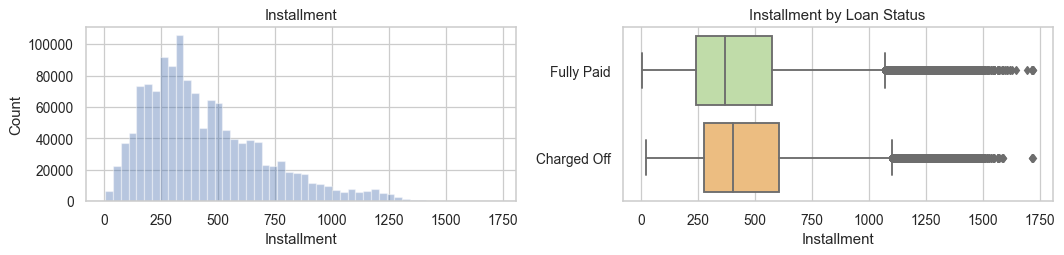

In [44]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [45]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,465.147994,262.774106,21.62,275.29,402.83,605.31,1717.63
Fully Paid,1076751.0,431.323226,260.759563,4.93,240.92,368.26,573.06,1719.83


Loans that charge off have \$30 higher installments on average.

## 5.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [46]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


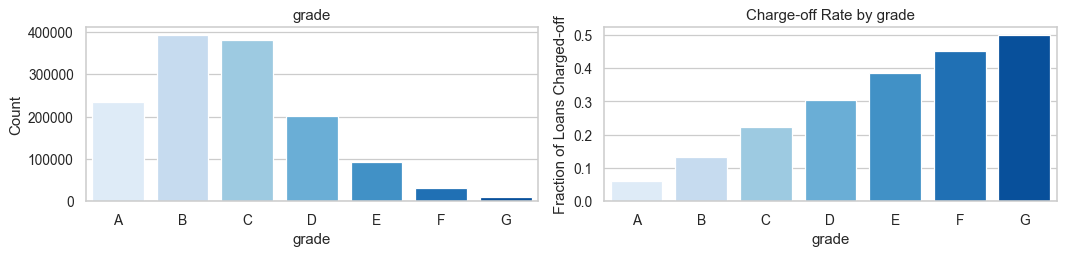

In [47]:
plot_var('grade', 'grade', continuous=False)

In [48]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [49]:
loans.drop('grade', axis=1, inplace=True)

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


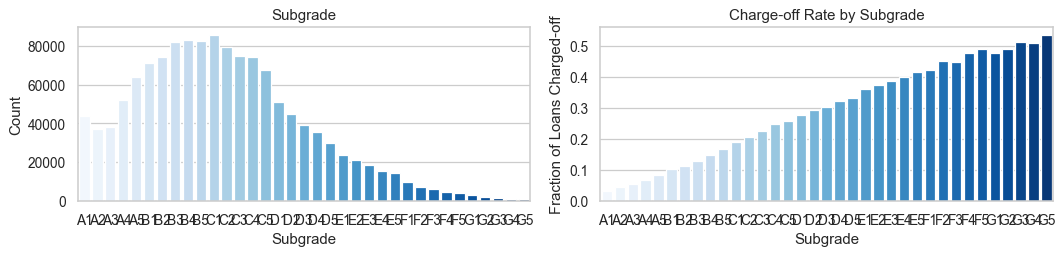

In [50]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [51]:
loans['emp_title'].describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [52]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [53]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [54]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [55]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [56]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [57]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [58]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     108061
1.0      88494
2.0     121743
3.0     107597
4.0      80556
5.0      84154
6.0      62733
7.0      59624
8.0      60701
9.0      50937
10.0    442199
NaN      78511
Name: emp_length, dtype: int64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


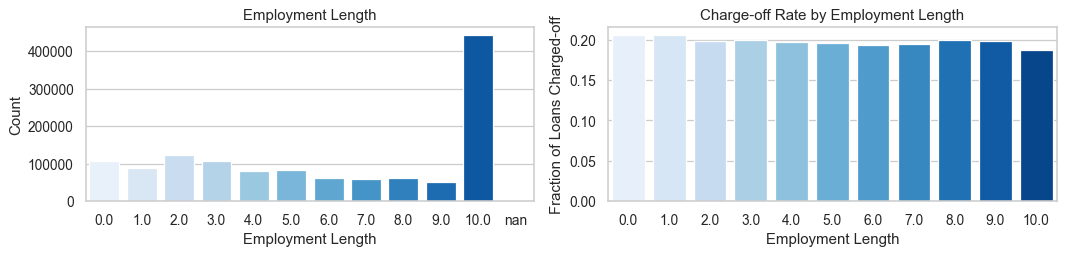

In [59]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [60]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [61]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [62]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


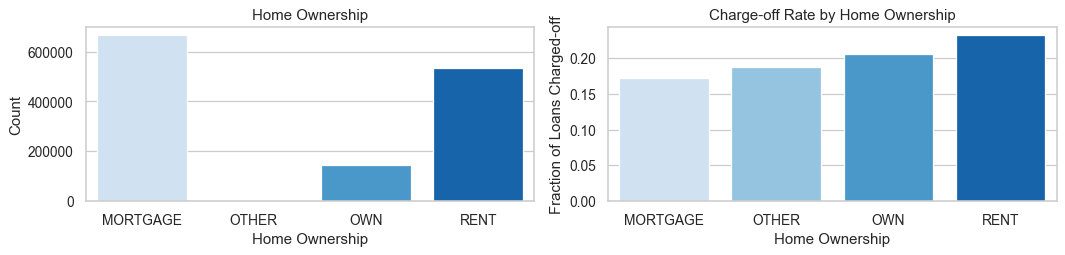

In [63]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [64]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.172077
OTHER       0.188285
OWN         0.206198
RENT        0.232165
Name: loan_status, dtype: float64

<ipython-input-83-864401b7aa79>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  loans.sort_values('int_rate')[loans['term']==36]['int_rate'].plot(kind='density')


<AxesSubplot:ylabel='Density'>

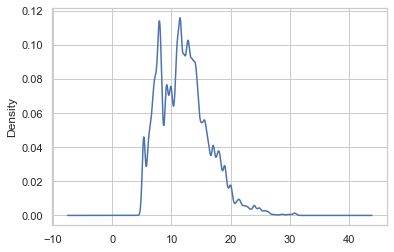

In [83]:

loans.sort_values('int_rate')[loans['term']==36]['int_rate'].plot(kind='density')

<AxesSubplot:ylabel='Density'>

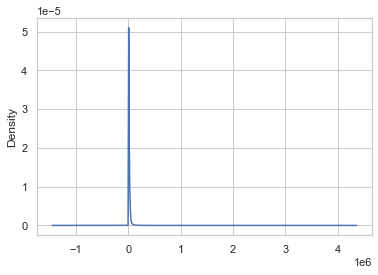

In [88]:
loans['revol_bal'].plot(kind='density')


## 5.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [65]:
loans['annual_inc'].describe()

count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [66]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [67]:
loans.drop('annual_inc', axis=1, inplace=True)

In [68]:
loans['log_annual_inc'].describe()

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


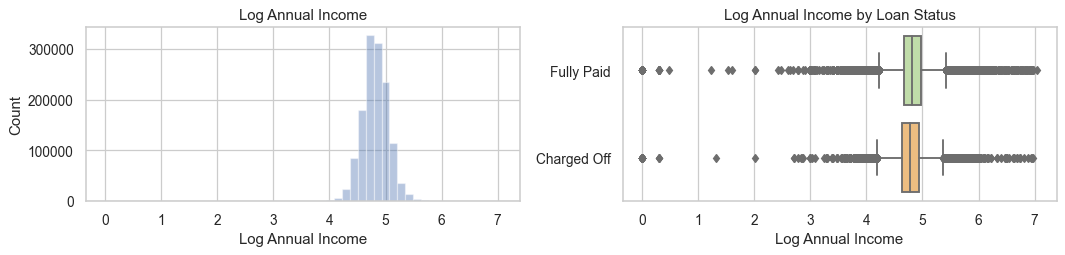

In [69]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [70]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,4.781756,0.241984,0.0,4.633479,4.778158,4.929424,6.977724
Fully Paid,1076751.0,4.820560,0.248526,0.0,4.672107,4.812920,4.968488,7.041361


## 5.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


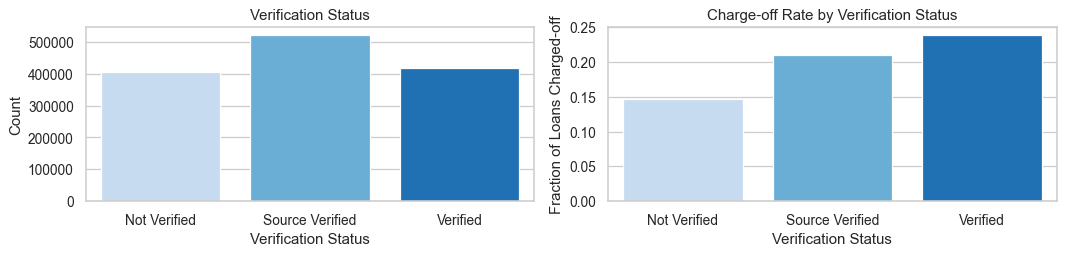

In [71]:
plot_var('verification_status', 'Verification Status', continuous=False)

## 5.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## 5.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [82]:
loans['purpose'].value_counts().values

array([780321, 295279,  87504,  77875,  29425,  15554,  15416,  14585,
         9480,   9065,   7253,   2294,    933,    326])

Calculate the charge-off rates by purpose:

In [72]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121622
car                   0.146795
credit_card           0.169270
educational           0.171779
home_improvement      0.177158
major_purchase        0.185998
vacation              0.191726
other                 0.210401
debt_consolidation    0.211469
medical               0.217757
house                 0.218806
moving                0.233544
renewable_energy      0.236870
small_business        0.297094
Name: loan_status, dtype: float64

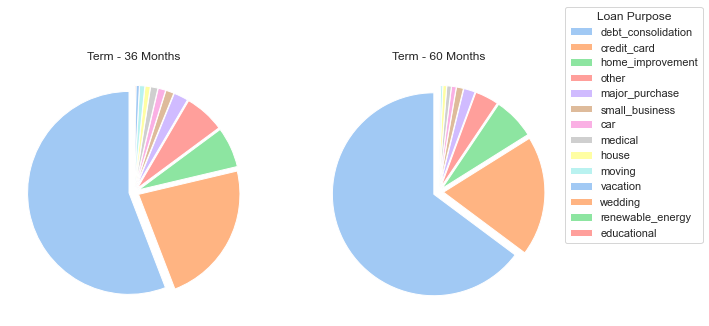

In [160]:
labels = np.array(loans.groupby('term')['purpose'].value_counts()[36].index)
sizes = np.array(loans.groupby('term')['purpose'].value_counts()[36].values)

explode = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]
colors = sns.color_palette("pastel")

fig1, ax1 = plt.subplots(1,2,figsize=(10,8))
ax1[0].pie(sizes, colors = colors, explode = explode, labels=None,startangle=90, 
        textprops = {'color': 'Black','fontsize':10},
                wedgeprops = {'linewidth': 1})

# Equal aspect ratio ensures that pie is drawn as a circle
ax1[0].set_title('Term - 36 Months')

labels = np.array(loans.groupby('term')['purpose'].value_counts()[60].index)
sizes = np.array(loans.groupby('term')['purpose'].value_counts()[60].values)

explode = [0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05]
colors = sns.color_palette("pastel")

ax1[1].pie(sizes, colors = colors, explode = explode, labels=None,startangle=90, 
        textprops = {'color': 'Black','fontsize':10},
                wedgeprops = {'linewidth': 1})


ax1[1].set_title('Term - 60 Months')

plt.legend(labels = labels,loc = (1, 0.3), title='Loan Purpose')
fig.tight_layout()

plt.show()

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

In [125]:
loans.groupby('term')['purpose'].value_counts(normalize=True)[36]

purpose
debt_consolidation    0.558425
credit_card           0.228514
home_improvement      0.064524
other                 0.064271
major_purchase        0.023006
medical               0.012983
car                   0.011938
small_business        0.011592
vacation              0.008316
moving                0.008256
house                 0.005225
wedding               0.001867
renewable_energy      0.000782
educational           0.000304
Name: purpose, dtype: float64

## 5.14 title

Data Dictionary: "The loan title provided by the borrower."

In [73]:
loans['title'].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [74]:
loans['title'].value_counts().head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

There are 60,298 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [75]:
loans.drop('title', axis=1, inplace=True)

## 5.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [76]:
loans['zip_code'].sample(5)

850801     773xx
1972607    972xx
513693     240xx
389688     900xx
191197     223xx
Name: zip_code, dtype: object

In [77]:
loans['zip_code'].nunique()

943

In [78]:
loans['addr_state'].sample(5)

313341     NY
164074     CA
1753917    VA
1947831    MI
282260     MD
Name: addr_state, dtype: object

In [79]:
loans['addr_state'].nunique()

51

There are a lot of different zip codes, so let's just keep the state column.

In [80]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [81]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.132086
ME    0.138424
VT    0.139517
IA    0.142857
OR    0.143850
NH    0.145759
WV    0.155187
CO    0.155269
WA    0.157565
SC    0.162769
KS    0.167438
WY    0.167693
MT    0.168716
UT    0.170586
CT    0.173763
RI    0.178675
IL    0.180974
WI    0.183510
GA    0.183927
ID    0.188277
MA    0.190528
CA    0.196104
AZ    0.196299
AK    0.196552
MN    0.197430
DE    0.197462
TX    0.198223
VA    0.199422
HI    0.202013
MI    0.202957
ND    0.204744
OH    0.205283
NC    0.207839
PA    0.207921
KY    0.209829
NJ    0.211212
MO    0.212935
MD    0.213085
SD    0.213227
NM    0.213665
TN    0.214079
IN    0.214082
FL    0.214746
NV    0.219223
NY    0.220435
LA    0.231821
OK    0.234753
AL    0.236321
AR    0.240868
NE    0.251813
MS    0.260777
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

## 5.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [82]:
loans['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

<AxesSubplot:>

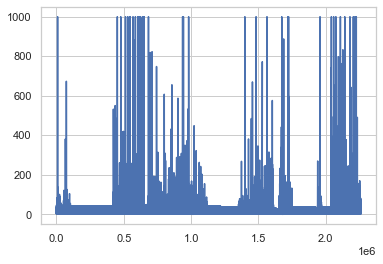

In [66]:
loans['dti'].plot()

<AxesSubplot:xlabel='dti', ylabel='loan_status'>

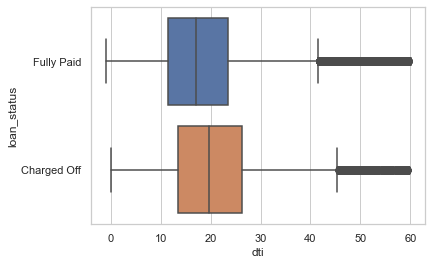

In [91]:
loans
sns.boxplot(data = loans[loans['dti']<60], x= 'dti', y = 'loan_status')
plt.xlabel('Debt to Income Ratio')


Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

Text(0.5, 1.0, 'Debt-to-income Ratio')

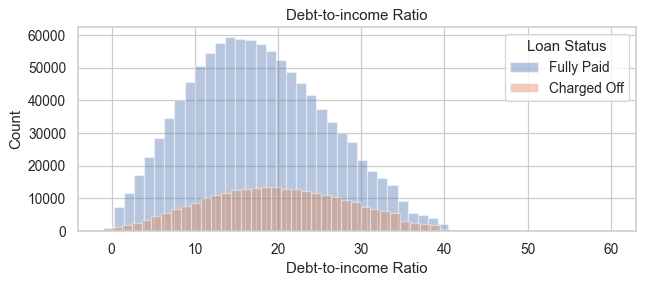

In [97]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60) & (loans['loan_status']=='Fully Paid'), 'dti'], label='Fully Paid', kde=False)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60) & (loans['loan_status']=='Charged Off'), 'dti'], label = 'Charged Off',kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [84]:
(loans['dti']>=60).sum()

1715

Very few. Compare the summary statistics by loan status:

In [85]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268488.0,20.171196,11.831747,0.0,13.55,19.76,26.31,999.0
Fully Paid,1076448.0,17.811629,10.935927,-1.0,11.43,17.11,23.44,999.0


/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


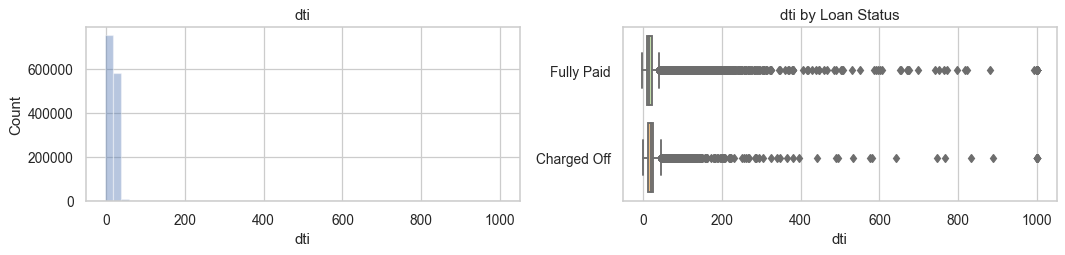

In [89]:
plot_var('dti', 'dti', continuous=True)

Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [87]:
loans['earliest_cr_line'].sample(5)

1054720    Jan-2001
166682     Oct-1984
1058907    Oct-2008
188792     Aug-1996
1944656    Dec-2001
Name: earliest_cr_line, dtype: object

In [88]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [89]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [90]:
loans['earliest_cr_line'].describe()

count    1.345310e+06
mean     1.998693e+03
std      7.608258e+00
min      1.934000e+03
25%      1.995000e+03
50%      2.000000e+03
75%      2.004000e+03
max      2.015000e+03
Name: earliest_cr_line, dtype: float64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


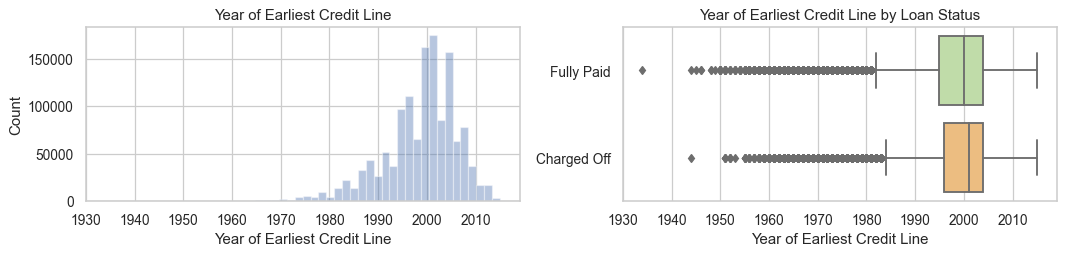

In [91]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [92]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.345310e+06,1.345310e+06
mean,6.961850e+02,7.001852e+02
std,3.185251e+01,3.185316e+01
min,6.250000e+02,6.290000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


Check the Pearson correlation between these values:

In [93]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [94]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [95]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


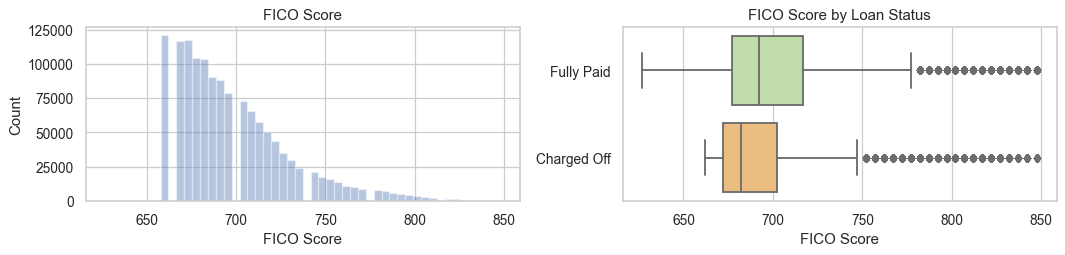

In [96]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [97]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,689.850145,25.948737,662.0,672.0,682.0,702.0,847.5
Fully Paid,1076751.0,700.263982,32.834008,627.0,677.0,692.0,717.0,847.5


Loans that charge off have a FICO score 10 points lower on average.

## 5.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Open Credit Lines')

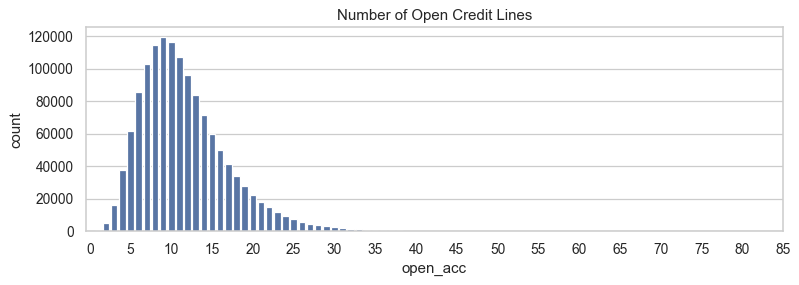

In [98]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans['open_acc'], order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [99]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,11.901269,5.637964,0.0,8.0,11.0,15.0,76.0
Fully Paid,1076751.0,11.516763,5.429354,0.0,8.0,11.0,14.0,90.0


/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


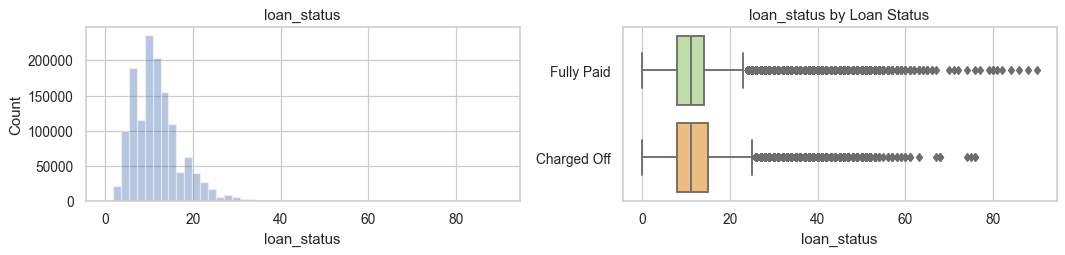

In [100]:
plot_var('open_acc', 'loan_status', continuous=True)

## 5.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [101]:
loans['pub_rec'].value_counts().sort_index()

0.0     1117425
1.0      190789
2.0       24435
3.0        7399
4.0        2630
5.0        1266
6.0         636
7.0         283
8.0         160
9.0          83
10.0         57
11.0         40
12.0         27
13.0         18
14.0          5
15.0          9
16.0          5
17.0          3
18.0          6
19.0          5
20.0          3
21.0          6
22.0          2
23.0          1
24.0          2
25.0          1
28.0          3
34.0          1
37.0          1
40.0          1
46.0          1
47.0          1
49.0          2
54.0          1
61.0          1
63.0          1
86.0          1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [102]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,0.246843,0.656732,0.0,0.0,0.0,0.0,86.0
Fully Paid,1076751.0,0.207403,0.587118,0.0,0.0,0.0,0.0,63.0


## 5.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [103]:
loans['revol_bal'].describe()

count    1.345310e+06
mean     1.624811e+04
std      2.232817e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.113400e+04
75%      1.975575e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [104]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [105]:
loans.drop('revol_bal', axis=1, inplace=True)

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


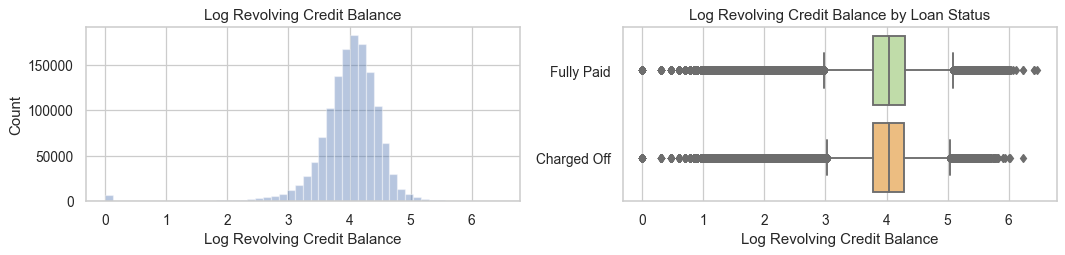

In [106]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [107]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,3.985882,0.515100,0.0,3.777499,4.044265,4.281079,6.242223
Fully Paid,1076751.0,3.993775,0.536333,0.0,3.773201,4.047314,4.299420,6.463122


There isn't a large difference in the means.

## 5.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [108]:
loans['revol_util'].describe()

count    1.344453e+06
mean     5.181002e+01
std      2.452107e+01
min      0.000000e+00
25%      3.340000e+01
50%      5.220000e+01
75%      7.070000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


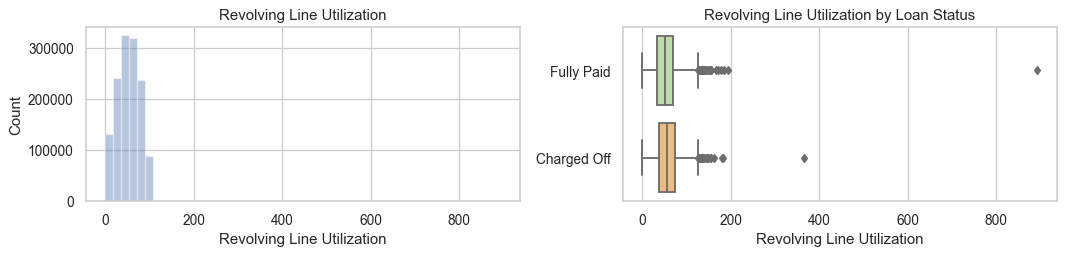

In [109]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [110]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268379.0,54.758433,23.865982,0.0,37.4,55.5,73.1,366.6
Fully Paid,1076074.0,51.074671,24.626821,0.0,32.5,51.3,70.1,892.3


## 5.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Total Number of Credit Lines')

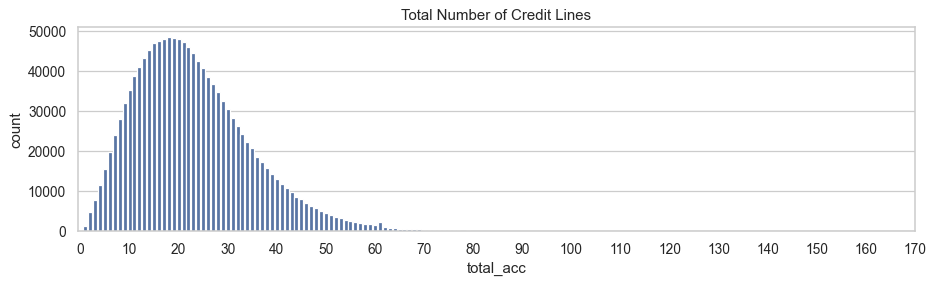

In [111]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans['total_acc'], order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [112]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,24.709356,12.117364,2.0,16.0,23.0,31.0,176.0
Fully Paid,1076751.0,25.048551,11.967683,2.0,16.0,23.0,32.0,162.0


No large differences here.

## 5.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


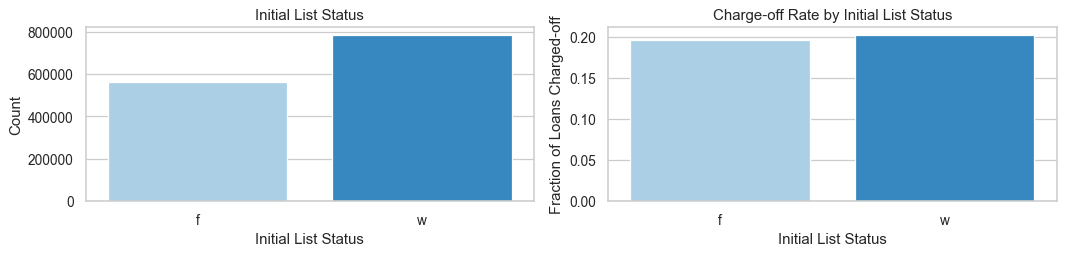

In [113]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [114]:
loans['application_type'].value_counts()

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [115]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.198721
Joint App     0.245891
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## 5.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [116]:
loans['mort_acc'].describe()

count    1.298029e+06
mean     1.670783e+00
std      2.000444e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [117]:
loans['mort_acc'].value_counts().head(10)

0.0    523837
1.0    226135
2.0    188941
3.0    139381
4.0     94920
5.0     57632
6.0     32539
7.0     16850
8.0      8378
9.0      4285
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [118]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.0,1.371032,1.825505,0.0,0.0,1.0,2.0,29.0
Fully Paid,1036356.0,1.746468,2.035279,0.0,0.0,1.0,3.0,51.0


Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [119]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     1176953
1.0      157696
2.0        7769
3.0        1583
4.0         396
5.0         141
6.0          46
7.0          15
8.0           9
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

/Users/prakharpatidar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


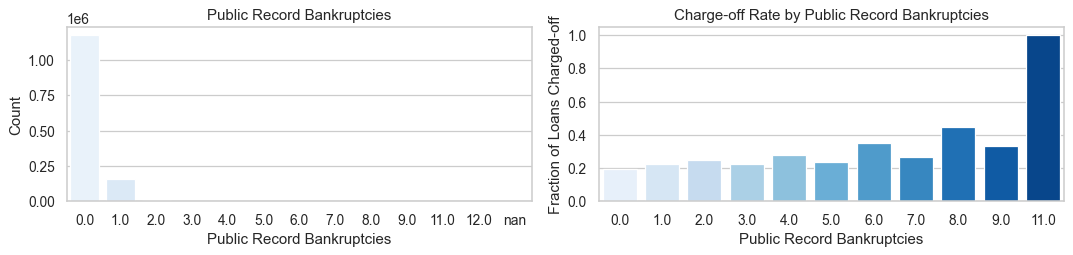

In [120]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

In [121]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [122]:
loans.shape

(1345310, 25)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [123]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [124]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

emp_length              0.058359
mort_acc                0.035145
revol_util              0.000637
pub_rec_bankruptcies    0.000518
dti                     0.000278
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [125]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [126]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [127]:
loans.shape

(1345310, 122)

Check our data with the new dummy variables:

In [128]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
1308943,1500.0,36,17.57,53.91,8.0,Mar-2014,23.54,2002,6.0,0.0,94.1,15.0,0.0,0.0,4.491376,667.0,3.927832,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
248423,15600.0,36,19.19,573.34,NaN,Jun-2015,23.70,2002,25.0,0.0,71.2,30.0,0.0,0.0,4.716012,662.0,4.452262,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
356542,15000.0,36,6.92,462.61,1.0,Mar-2015,19.13,1994,9.0,0.0,67.7,23.0,3.0,0.0,4.845104,702.0,4.590998,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1065364,28000.0,36,7.89,876.00,10.0,Feb-2016,23.52,1983,27.0,0.0,42.6,63.0,3.0,0.0,4.999570,687.0,4.523902,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1627303,10200.0,36,7.49,317.24,10.0,May-2011,13.80,1989,9.0,0.0,49.5,53.0,NaN,0.0,5.096913,737.0,4.189266,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [129]:
loans.shape

(1345310, 122)

## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [130]:
loans['issue_d'].sample(5)

2009732    Jul-2016
962435     Apr-2017
288841     May-2015
1908739    Sep-2012
453988     Mar-2018
Name: issue_d, dtype: object

Are there any missing values?

In [131]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [132]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [133]:
loans['issue_d'].sample(5)

599769    2017-08-01
2131220   2017-10-01
355460    2015-03-01
1983180   2016-08-01
1092818   2016-01-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [134]:
loans['issue_d'].describe()

count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

There are only 124 unique issue dates over the 10-year period because we only have month/year information. In this particular dataset, the first loans were issued in June 2007, and the most recent loans were issued in September 2017. The busiest month was October 2014 with 33,699 loans funded in that month. What is the distribution of loans funded in each year?

Text(0.5, 1.0, 'Loans Funded per Year')

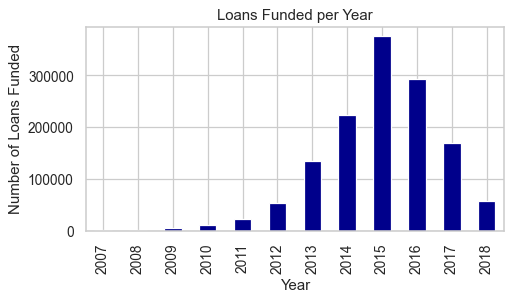

In [135]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [136]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [137]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    1345310
Number of loans in the full dataset: 1345310


What is the test size?

In [138]:
loans_test.shape[0] / loans.shape[0]

0.11111639696426846

About 10.2%. The partition looks good, so we can delete the original `loans` dataframe:

In [139]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [140]:
loans_train['issue_d'].describe()

count                 1195824
unique                    120
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2017-05-01 00:00:00
Name: issue_d, dtype: object

In [141]:
loans_test['issue_d'].describe()

count                  149486
unique                     19
top       2017-08-01 00:00:00
freq                    15488
first     2017-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from June 2007 to June 2016. The test set includes loans from July 2016 to September 2017.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [142]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:

In [143]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [144]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [145]:
loans_train.shape

(1195824, 121)

# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, $F$-statistic, and $p$ value of each predictor with the response variable `charged_off`.

In [146]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [147]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

$F$-statistics:

In [148]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [149]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [150]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [151]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.260727,87219.488733,0.0
1,term,0.182364,41137.034592,0.0
2,fico_score,-0.131392,21007.091229,0.0
3,dti,0.100747,12261.190248,0.0
4,mort_acc,-0.072414,6054.501347,0.0
5,sub_grade_A4,-0.065653,5176.669917,0.0
6,log_annual_inc,-0.065324,5124.653113,0.0
7,sub_grade_A5,-0.065204,5105.863849,0.0
8,sub_grade_A2,-0.063053,4773.117611,0.0
9,home_ownership_RENT,0.062418,4677.205362,0.0


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [152]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
100,addr_state_WY,-0.003484,14.512058,0.000139
101,addr_state_KY,0.003284,12.899558,0.000329
102,addr_state_RI,-0.003236,12.524695,0.000402
103,addr_state_NC,0.003228,12.462234,0.000415
104,addr_state_NM,0.002456,7.211381,0.007244
105,purpose_renewable_energy,0.002105,5.297637,0.021355
106,addr_state_TX,-0.001797,3.853799,0.049634
107,addr_state_SD,0.001611,3.102581,0.078169
108,addr_state_MI,0.001250,1.865744,0.171964
109,purpose_vacation,-0.001205,1.737135,0.187502


It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Random forest
3. k-nearest neighbors

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [ ]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [ ]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [ ]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [ ]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [ ]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [ ]:
grid_sgdlogreg.best_score_

0.7114120054770521

Best hyperparameters:

In [ ]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 Random forest classifier
<a id="8.2"></a>

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [157]:
!pip install delayed

     |████████████████████████████████| 173 kB 16.8 MB/s eta 0:00:01


In [155]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.impute import SimpleImputer

In [156]:
pipeline_rfc = imbpipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('smote', BorderlineSMOTE()),
    ('model', RandomForestClassifier())
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

In [157]:
pipeline_rfc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
param_grid_rfc = { # The number of randomized trees to build
}

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [155]:
# grid_rfc = GridSearchCV(estimator=pipeline_rfc, 
#                         param_grid=param_grid_rfc, 
#                         scoring='f1', 
#                         n_jobs=1, 
#                         pre_dispatch=1, 
#                         cv=5, 
#                         verbose=1, 
#                         return_train_score=False)

TypeError: ignored

In [ ]:
# grid_rfc.fit(X_train, y_train)

Mean cross-validated F1 score of the random forest:

In [ ]:
# grid_rfc.best_score_

Not quite as good as logistic regression, at least according to this metric.

## 8.3 k-nearest neighbors
<a id="8.3"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

In [ ]:
param_grid_knn = {
    'lda__n_components': [3, 9], # Number of LDA components to keep
    'model__n_neighbors': [5, 25, 125] # The 'k' in k-nearest neighbors
}

In [ ]:
# grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [ ]:
# grid_knn.fit(X_train, y_train)

Mean cross-validated AUROC score of the best model:

In [ ]:
# grid_knn.best_score_

Best hyperparameters:

In [ ]:
# grid_knn.best_params_

Only 3 LDA components are necessary for kNN to perform almost as well as logistic regression!

## 8.4 Tune hyperparameters on the chosen model more finely
<a id="8.4"></a>

The three models performed quite similarly according to the AUROC:

In [ ]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')

Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [ ]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

In [ ]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [ ]:
grid_sgdlogreg.fit(X_train, y_train)

Mean cross-validated AUROC score of the best model:

In [ ]:
grid_sgdlogreg.best_score_

Best hyperparameters:

In [ ]:
grid_sgdlogreg.best_params_

By some coincidence, the optimal hyperparameters here are the same as from our first grid search for logistic regression!

## 8.5 Test set evaluation
<a id="8.5"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, PrecisionRecallDisplay

In [ ]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

The test set AUROC score is somewhat lower than the cross-validated score (0.713).

In [ ]:
y_true = np.array(y_test)
y_pred = pipeline_rfc.predict(X_test)

print(classification_report(y_true,y_pred))

In [ ]:
y_score = pipeline_rfc.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating three different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.689 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to linear measures of correlation between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.